# Intro

This notebook contains an initial analysis for a classification problem.
At hand I have historical data of transaction for certain rental contracts.
I will study how could we calssify good from bad tenant looking at their past history.

The possible approaces include unsupervised learning as clustering and supervise learning for predictions and testing. I used valrious Deep Neural Networds architectures to train the model. 

This is a prototype for a possible classification application in the real-estate market.

In [14]:
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import preprocessing
import pandas as pd
#import modin.pandas as pd
import datetime
import calendar
import time
from operator import attrgetter


# These functions will be very handy for clean and fast manipulation of the database

# adds a month to a datetime type
def add_months(sourcedate, months):
    '''adds a month to a datetime type'''
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return datetime.date(year, month, day)

# gets contracts associated with a tenant using tenant_id
def get_contracts(tenant):
    '''
    Gets contracts associated with a tenant using tenant_id
    A list of tenants may also be passed.
    '''
    if type(tenant)==str:
        tenant=[tenant]
    df=contracts[contracts['tenant_id'].isin(tenant)].reset_index(drop=True)
    return df

# gets hisory of transitions for a speacific contract using contract_id
def get_history(contract):
    '''
    Gets hisory of transitions for a speacific contract using contract_id.
    A list of contracts may also be passed.
    '''
    if not type(contract)==list:
        contract=[contract]
    df=transactions[transactions['contract_id'].isin(contract)].reset_index(drop=True)
    return df

# gets tenant associated with a contract using contract_id
def get_tenant(contract):
    '''
    Gets tenant associated with a contract using contract_id
    '''
    df=tenants[tenants['c_ids'].apply(lambda x: contract in x)]
    return df
 
# gets contract info from contract.csv dataframe using contract_id
def get_cinfo(contract):
    '''
    Gets contract info from contract.csv dataframe using contract_id
    A list of contracts may also be passed.
    '''
    if not type(contract)==list:
        contract=[contract]
    df=contracts[contracts['contract_id'].isin(contract)].reset_index()
    return df

# Looking at the Data

Here I start the analysis by gathering the main infos about the dataset. I answer each of the asked question with a small cell of code that provides the answer. The cells do not need to be re-run as the result will be printed.

Here I print out the size of the dataframes, both contracts and transactions. Transaction dates span from 2014-12-02 to 2017-12-31. Contracts are unique. There is both some transactions without a corresponding contract, and some contracts without a corresponding transaction. These are only 53 for each of the mentioned cases. We simply drop these entries for the later analysis.

In [15]:
# Load Data
# Here the basic info about dataset size, missing entries and date range
# I also change the time of dates to datetime for manipulation ease


contracts=pd.read_csv('contracts.csv')
contracts['contract_start']=pd.to_datetime(contracts['contract_start'])
contracts['contract_end']=pd.to_datetime(contracts['contract_end'])
print('tot_num_contracts:',len(contracts['contract_id'].unique()))

transactions=pd.read_csv('transactions.csv')
transactions['Payment_date']=pd.to_datetime(transactions['Payment_date'])
print('tot_num_transaction:',len(transactions))

# Last and firt date of transaction in the database
first_date=sorted(transactions['Payment_date'])[0]
print('Earliest Date recorded:',first_date)
last_date=sorted(transactions['Payment_date'])[-1]
print('Latest Date recorded:',last_date)

# Contracts without transactions/ Transactions without Contract info
all_con_t=set(transactions['contract_id'])
all_con_c=set(contracts['contract_id'])
missing_in_t=all_con_c-all_con_t
print('missing_in_transactions:',len(missing_in_t))
missing_in_c=all_con_t-all_con_c
print('missing_in_contracts:',len(missing_in_c))

# Drop contracts without transaction history
contracts=contracts[~(contracts['contract_id'].isin(missing_in_t))].reset_index(drop=True)
print('tot_num_contracts after removing missing entries:',len(contracts['contract_id'].unique()))

tot_num_contracts: 11218
tot_num_transaction: 270761
Earliest Date recorded: 2014-12-02 00:00:00
Latest Date recorded: 2017-12-31 00:00:00
missing_in_transactions: 53
missing_in_contracts: 53
tot_num_contracts after removing missing entries: 11165


# Questions

1. How many unique contracts are there in total?
2. How many unique contracts are there with a link to transaction information?
3. How many unique tenants?
4. How many tenants with multiple contracts?
5. How many contracts such tenants have?
6. How many tenants have a total contract history with less than 3, 6, and 12 months of history,
and with at least 18 and 24 months of history?
7. How many tenants have used only one payment method? How many more than one?
8. What is the relationship between deposit and rent amount agreed in the contract?
9. Can you find an example of the transactional history for an evicted tenant, for each possible
cause of eviction, and explain the cause of eviction?
10. How many evictions, pertype, are there?

# Initial analysis

As seen from the initial data there is:
- 11218 contracts in 'contracts.csv'
- 53 of these do not have transactions history, so we have 11165 contracts with history
- 53 contracts have history but miss general information


We consider a unique tenant as one with a unique combination of name, surname and dob.
To be sure that there is no two tenants with same name, surname and dob we can look at the contrats history and make sure there are no overlaps, as each tenant can have only one contract at the time.


In [16]:
unique_tenants=contracts[['name','surname','dob']].drop_duplicates()
unique_tenants=list(unique_tenants['name']+unique_tenants['surname']+unique_tenants['dob'])
print('unique_tenants:',len(unique_tenants))

unique_tenants: 9951



I add a tenant_id as the string sum of name, surname and dob and quickly check what is the amount of contracts for each tenant. The majority of the tenants have 1 or 2 contracts, only 70 tenants have more then 2. The maximum amount of contract per tenant is 4.

In [17]:
# Add tenand_id both in contracts and transactions
contracts['tenant_id']=contracts['name']+contracts['surname']+contracts['dob']
map_t=dict()
for tenant in unique_tenants:
    t_contracts=list(get_contracts(tenant)['contract_id'])
    for t in t_contracts:
        map_t[t]=tenant
transactions['tenant_id']=transactions['contract_id'].map(map_t)

num_con_df=contracts.groupby('tenant_id').count()[['contract_id']].rename(columns={'contract_id':'num_contracts'})
for i in range(1,5):
    print('tenants with {} contracts:'.format(i),len(num_con_df[num_con_df['num_contracts']==i]))
print('tenants with >4 contracts:',len(num_con_df[num_con_df['num_contracts']>4]))

tenants with 1 contracts: 8809
tenants with 2 contracts: 1072
tenants with 3 contracts: 68
tenants with 4 contracts: 2
tenants with >4 contracts: 0



Most tenants have a 36/35 months of transactions history. Other tenants are quite balanced from 1 months to 34 (each case has ~150 tenants in it). For the specific questions I find:

- total contracts history with < 3 months: 425
- total contracts history with < 6 months: 965
- total contracts history with < 12 months: 1983
- total contracts history with >= 18 months: 7028
- total contracts history with >= 24 months: 6093

In [39]:
# SLOW CELL

months_differences=[]
for tenant in unique_tenants:
    t_contracts=list(get_contracts(tenant)['contract_id'])

    full_hist=pd.DataFrame()
    for con in t_contracts:
        full_hist=pd.concat([full_hist,get_history(con)])
   
    dates=sorted(set(full_hist['Payment_date'].dropna()))
    months_differences.append(dates[-1].to_period('M')-dates[0].to_period('M'))
months_differences=pd.Series(months_differences).apply(attrgetter('n'))

,Count
36,4073
35,450
5,191


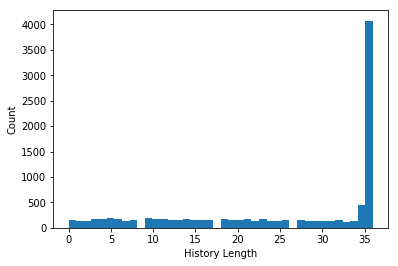

In [40]:
counter_date_span=pd.DataFrame(Counter(months_differences),index=['Count']).T.sort_values('Count',ascending=False)
_,_,_=plt.hist(months_differences,bins=40)
plt.xlabel('History Length')
plt.ylabel('Count')
counter_date_span[:3]

In [42]:
for i in [3,6,12]:
    print(f'total contracts history with < {i} months:',counter_date_span\
          .reset_index()[counter_date_span.reset_index()['index']<i].sum()['Count'])
for i in [18,24]:
    print(f'total contracts history with >= {i} months:',counter_date_span\
          .reset_index()[counter_date_span.reset_index()['index']>=i].sum()['Count'])

total contracts history with < 3 months: 425
total contracts history with < 6 months: 965
total contracts history with < 12 months: 1983
total contracts history with >= 18 months: 7028
total contracts history with >= 24 months: 6093



Most tenants use 1 payment type, some use 2, none use more than 2.
the most used type by tenants is:
- 'DIRECT_DEBIT': favourite by 7915  tenants
- 'BANK_TRANSFER': favourite by 1512 tenants
- 'CASH': favourite by 524 tenants

In [43]:
type_tran=transactions.groupby('tenant_id')['payment_method'].nunique()
print('tenants using 1 payng method:',sum(type_tran==1))
print('tenants using 2 payng method:',sum(type_tran==2))
print('tenants more than 2 payng method:',sum(type_tran>2))
Counter(transactions.groupby('tenant_id')['payment_method'].agg(lambda x:x.value_counts().index[0]))

tenants using 1 payng method: 9607
tenants using 2 payng method: 344
tenants more than 2 payng method: 0


Counter({'BANK_TRANSFER': 1512, 'DIRECT_DEBIT': 7915, 'CASH': 524})


All the deposits avaliable (for contracts with a starting date within the dataset range) have a ratio of 3 with respect to the rent. We could Assume that the contracts that started before the avaliable dates also have a deposit 3 times the rent, and compare the retunrs given at the end of the contract for confirmation (in the case of no eviction, we will discuss this later below). There are 6298 contracts with a starting date within our data range (56% of all contracts).

In [44]:
temp=contracts[contracts['contract_start']>=first_date][['contract_id','contract_start','rent','tenant_id']]
temp_2=transactions[['contract_id','tenant_id','Payment_date','Amount']]
temp_fin=temp.merge(temp_2,left_on=['contract_id','contract_start'],
           right_on=['contract_id','Payment_date'],
           how='inner')
# transactions at the starting date are always the first month of rent and the deposit (3 times rent)
print(Counter(temp_fin['Amount']/temp_fin['rent']))
print('contracts with starting date within our data range:',len(temp),
      ('({}%)'.format(int(100*len(temp)/len(contracts)))))

Counter({3.0: 6298, 1.0: 6298})
contracts with starting date within our data range: 6298 (56%)




There is two kinds of evictions
- case 1: the tenant do not pay rent for 2 months. As a consequence the landlord keeps the deposit and close the contract
- case 2: the tenant pays the month with a large delay (>30 days) paying a fee. The landlord closed the contract and return the deposit minus one_rent for the last month.

The two cases can be found in the dataframe by usuing the folloing:
- case 1: contains 2 NaN values in the Amount column and a transaction with Amount euqal to 0. Also the Payment_date column contains a NaN date.
- case 2: Contains 1 NaN in Amount column and the returned deposit is less than the total deposit

There is 201 cases of type_1 eviction and 114 cases of type_2 eviction for a total of 315 (2%) evictions in the dataframe. There are also 4 cases of type_1 eviction that are to be completed.
Additionally is to important to notice:
-  the dataframe contains only 808 (7%) contracts that are open and closed between the window of dates present in this database. 
- There are also 2150 (19%) contracts that are closed within the date range of the database.

In [45]:
# SLOW CELL
# types of evictions
selected_con=contracts['contract_id']
count_1=0
count_2=0
eviction_map=dict()
for con in selected_con:
    temp=get_history(con)
    if (sum(temp['Payment_date'].isna())==1):
        count_1+=1
        eviction_map[con]="Type_1"
    elif (sum(temp['Amount'].isna())==1):
        count_2+=1
        eviction_map[con]="Type_2"
print('type_1_eviction:',count_1)
print('type_2_eviction:',count_2)

type_1_eviction: 201
type_2_eviction: 114


In [46]:
# Opend and Closed contracts
closed_open_c=contracts[(~contracts['contract_end'].isna())&
                      (contracts['contract_start']>=first_date)]['contract_id']
print('Opend and Closed contracts:',len(closed_open_c))
# Closed contracts
closed_c=contracts[(~contracts['contract_end'].isna())]['contract_id']
print('Opend and Closed contracts:',len(closed_c))

Opend and Closed contracts: 808
Opend and Closed contracts: 2150


## Labeling data

As we noticed, there are few clear cases of eviction, and surelly these can be considered as a negative
tenant behaviour. I am going to add a label to each contract in the dataset that shows if a contract was closed negativly or not. 

In the previous cells I created a simple map that now we use to add this column to the contract dataframe. Thanks to this we can already check that we only have tenants that have been evicted once, not more.

Finally, I save the dataframe to csv, this will be used in the next notebook for training.

In [12]:
contracts['eviction']=contracts['contract_id'].map(eviction_map)

In [13]:
print('Number of tenants evicted 1 time:',
      sum(contracts[~contracts['eviction'].isna()].groupby('tenant_id').count()['eviction']==1))
print('Number of tenants evicted >1 time:',
      sum(contracts[~contracts['eviction'].isna()].groupby('tenant_id').count()['eviction']>1))

Number of tenants evicted 1 time: 315
Number of tenants evicted >1 time: 0


In [14]:
contracts.head()

,contract_id,name,surname,dob,postcode,rent,contract_start,contract_end,tenant_id,eviction
0,1465348858,Charlie,Jones,1980-02-29,W13 9DF,2180.0,2016-06-08,NaT,CharlieJones1980-02-29,NaN
1,1512527932,Megan,Harding,1980-01-01,EC1V0LA,3140.0,2017-12-06,NaT,MeganHarding1980-01-01,NaN
2,1364692954,Laura,Baker,1989-10-14,TW3 1TS,940.0,2013-03-31,NaT,LauraBaker1989-10-14,NaN
3,1359165099,Adam,Richardson,1992-12-07,SE1 8YD,2240.0,2013-01-26,2015-04-25,AdamRichardson1992-12-07,NaN
4,1430526767,Mussammed,Carr,1978-06-03,SW159EL,2320.0,2015-05-02,NaT,MussammedCarr1978-06-03,NaN


In [15]:
contracts.to_csv('contracts_updated.csv',index=False)

# Transaction DataFrame

Here I calculated the delay of payment and the due dates for each contract. Some manipulation is needed as we need to consider the double payment at the start of the contract (rent+deposit).

Also this updated dataframe is saved for future use in the training notebook

In [36]:
#SLOW CELL (Needed time to run this cell: 437 sec)

def my_fun():
    start=time.time()
    transactions_update=pd.DataFrame()
    
    for tenant in unique_tenants:
        #print(tenant)
        cons=get_contracts(tenant)
        history=pd.DataFrame()
        for con in cons['contract_id']:
            #print(con)
            temp_history=get_history(con)
            cinfo=get_cinfo(con)
            due_dates=[add_months(cinfo['contract_start'][0],j) for j in range(300)]
            due_dates=[d for d in due_dates if (pd.to_datetime(d)<=last_date) \
                 and (pd.to_datetime(d)<=pd.to_datetime(cinfo['contract_end'].fillna(last_date)[0]))\
                and (pd.to_datetime(temp_history['Payment_date'][0]).date()-d<=pd.Timedelta(20,'D'))]
            if pd.to_datetime(cinfo['contract_start'][0])>=first_date:
                due_dates=[due_dates[0]]+list(due_dates)
            if pd.to_datetime(cinfo['contract_end'].fillna(last_date)[0])<=last_date:
                due_dates=due_dates+[add_months(due_dates[-1],1)]
            #print(len(due_dates))
            #print(len(history))
            miss_dates=len(due_dates)-len(temp_history)
            delay=[]
            if len(due_dates)<len(temp_history):
                print(due_dates)
                display(temp_history)
            for j in range(len(temp_history)):
                delay.append(pd.to_datetime(temp_history['Payment_date'][j]).date()-due_dates[j])
            try:
                temp_history['due_date']=due_dates
            except:
                temp_history['due_date']=due_dates[:-miss_dates]

            temp_history['delay']=delay
            history=pd.concat([history,temp_history])
        transactions_update=pd.concat([transactions_update,history.reset_index()\
        .rename(columns={'index':'index_history_contract'})])

    transactions_update=transactions_update.reset_index().rename(columns={'index':'index_history_tenant'})

    end=time.time()
    print('Needed time to run this cell:',end-start)
    
    return transactions_update

transactions_update=my_fun()

Needed time to run this cell: 437.33953881263733


In [37]:
len(transactions_update)

268853

In [38]:
transactions_update.to_csv('transactions_updated.csv',index=False)